In [213]:
# Recurrent Neural Network (LSTM)


In [214]:
'''Part 1 - Data Processing'''
# Importing lib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [215]:
# Importing the training set
dataset_train = pd.read_csv(r'./Part 3 - Recurrent Neural Networks/Google_Stock_Price_Train.csv')
dataset_train


# 選擇一定範圍的csv
training_set = dataset_train.iloc[:,:2]


# Date欄位的單位設置為 date time
training_set['Date'] = pd.to_datetime(training_set['Date'], format = '%m/%d/%Y')


# # Date欄位視為Index -> 不屬於表格內的內容
# training_set = training_set.set_index('Date')


# 將pd 轉換為矩陣array純數值 array
training_set = training_set.values
training_set

array([[Timestamp('2012-01-03 00:00:00'), 325.25],
       [Timestamp('2012-01-04 00:00:00'), 331.27],
       [Timestamp('2012-01-05 00:00:00'), 329.83],
       ...,
       [Timestamp('2016-12-28 00:00:00'), 793.7],
       [Timestamp('2016-12-29 00:00:00'), 783.33],
       [Timestamp('2016-12-30 00:00:00'), 782.75]], dtype=object)

In [216]:
# array[列(筆數),欄[行數]]
type(training_set[1,0])

pandas._libs.tslibs.timestamps.Timestamp

In [217]:
training_set.shape

(1258, 2)

In [218]:
training_set[:,1]

array([325.25, 331.27, 329.83, ..., 793.7, 783.33, 782.75], dtype=object)

In [219]:
# Feature Scaling (Z-score Standardisation標準化 or Normalization 歸一化) -> 這邊使用歸一化 MinMax Normalization
from sklearn.preprocessing import MinMaxScaler


# 設置MinMax 歸一化的數據 0~1
sc = MinMaxScaler(feature_range=(0,1))
training_set_new = sc.fit_transform(training_set[:,1].reshape(-1, 1)).reshape(-1,)
training_set[:,1] = training_set_new

# fit 的意思 : 會記錄我們目前訓練數據的Max(最大值)、Min(最小值) = 歸一化數值的特徵(規矩)-> 以後預測未知的數據在做歸一化時以這個為基準做歸一化
# -> 這個資料對於我的模型所得到的"平均值mean"的距離 std
training_set_scaled = training_set
training_set_scaled

array([[Timestamp('2012-01-03 00:00:00'), 0.08581367661284323],
       [Timestamp('2012-01-04 00:00:00'), 0.09701242651983033],
       [Timestamp('2012-01-05 00:00:00'), 0.0943336557779596],
       ...,
       [Timestamp('2016-12-28 00:00:00'), 0.9572512835776472],
       [Timestamp('2016-12-29 00:00:00'), 0.9379604137212592],
       [Timestamp('2016-12-30 00:00:00'), 0.9368814643946723]],
      dtype=object)

In [220]:
# Creating a data Structure with 60 timesteps and 1 output -> 回顧60個時間點，進而預估未來1個的時間點
# 回顧的時間點(查看狀態)的多寡必定會影響預測未來的數值
look_back = 60
time_step = 1

X_train = []
Y_train = [] 


# 一個dataset，共有len(training_set) - look_back - time_step + 1
# 從look_back處開始滑動 -> 至 len(training_set) - time_step + 1 處
for i in range(look_back, len(training_set_scaled) - time_step +1):
    X_train.append(training_set_scaled[i - 60 : i, 1])
    Y_train.append(training_set_scaled[i : i + time_step, 1])
    
X_train, Y_train = np.array(X_train).astype(float), np.array(Y_train).astype(float)



    

In [221]:
# Reshaping ， 重塑時序資料的型態 (一般情況可不用做此步驟)
# 真正的時序資料型態 = (時序資料(窗口)數量, 窗口有多少個時間點, 每個時間點共有幾個特徵(此處只有一個))
X_train = X_train.reshape(len(X_train),len(X_train[0]),1)
X_train.shape

(1198, 60, 1)

In [222]:
Y_train.shape

(1198, 1)

In [223]:
'''Part  - Building the RNN(LSTM)'''
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [224]:
len(X_train[0][0])

1

In [225]:
type(Y_train.shape[1])

int

In [226]:
# Initialising the RNN (LSTM)
# 預估時序資料 -> 連續資料 -> 未來趨勢 -> 回歸(Regression)
model = Sequential()


# Addint the LSTM layer and some Dropout regularization
# return_sequence : 如果要建立多層 LSTM的話，要用 True
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))


# 增進或者微調Model的選項 -> Dropout ， 在訓練時丟去一定比例(Drop out rate)的神經元去訓練，但最終訓練時神經元數目是一樣的
# model.add(Dropout(Drop out Rate)) -> 通常Drop 20% -> 0.2即可
model.add(Dropout(0.2))


# 再度增加LSTM模型層數
# 增加第二層LSTM + Dropout 層
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))


# 增加第三層LSTM + Dropout 層
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))


# 增加最後一層LSTM + Dropout 層 以及 最後的一維全連接層 -> 最後輸出進行回歸決策
model.add(LSTM(units = 50)) # LSTM下一層不再接LSTM層的話，就不用return_sequences = True
model.add(Dropout(0.2))
# 全連接層為我們輸出的結果 -> 下一個時間的預測結果(資料型態) = Y 標籤.shape = 預估幾個時間點的幾個特徵
# 因為 Dense 全連接層的神經元只能是個"數字" -> 所以Output數量是 預測時間點數 * 每個時間點的特徵數
model.add(Dense(units = 1))

In [227]:
# Compiling the RNN (LSTM)
# MSE 通常是用在回歸 -> 預測連續數據時使用
model.compile(loss = 'mse', optimizer = 'adam' )

In [228]:
# Fitting the RNN (LSTM) to the Training set
model.fit( X_train,  Y_train, epochs = 150, batch_size = 32)

Epoch 1/150
38/38 [==============================] - 4s 41ms/step - loss: 0.0521
Epoch 2/150
38/38 [==============================] - 1s 28ms/step - loss: 0.0076
Epoch 3/150
38/38 [==============================] - 1s 29ms/step - loss: 0.0064
Epoch 4/150
38/38 [==============================] - 1s 29ms/step - loss: 0.0056
Epoch 5/150
38/38 [==============================] - 1s 30ms/step - loss: 0.0051
Epoch 6/150
38/38 [==============================] - 1s 29ms/step - loss: 0.0049
Epoch 7/150
38/38 [==============================] - 1s 30ms/step - loss: 0.0046
Epoch 8/150
38/38 [==============================] - 1s 27ms/step - loss: 0.0047
Epoch 9/150
38/38 [==============================] - 1s 26ms/step - loss: 0.0049
Epoch 10/150
38/38 [==============================] - 1s 26ms/step - loss: 0.0043
Epoch 11/150
38/38 [==============================] - 1s 27ms/step - loss: 0.0039
Epoch 12/150
38/38 [==============================] - 1s 26ms/step - loss: 0.0036
Epoch 13/150
38/38 [=====

In [229]:
'''Part 3 - Making the Predction and Visualizing the results'''

# 讀取測試數據 -> 處理測試(未知)數據的方式跟我們處理訓練數據集的方式相同!
# Importing the training set
dataset_test = pd.read_csv(r'./Part 3 - Recurrent Neural Networks/Google_Stock_Price_Test.csv')
dataset_test



,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"
5,1/10/2017,807.86,809.13,803.51,804.79,"1,176,800"
6,1/11/2017,805.00,808.15,801.37,807.91,"1,065,900"
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"
8,1/13/2017,807.48,811.22,806.69,807.88,"1,099,200"
9,1/17/2017,807.08,807.14,800.37,804.61,"1,362,100"


In [230]:

# 選擇一定範圍的csv
test_set = dataset_test.iloc[:,:2]


# Date欄位的單位設置為 date time
test_set['Date'] = pd.to_datetime(test_set['Date'], format = '%m/%d/%Y')


# # Date欄位視為Index -> 不屬於表格內的內容
# training_set = training_set.set_index('Date')


# 將pd 轉換為矩陣array純數值 array
real_stock_price = test_set.values[:,1]
real_stock_price = real_stock_price.reshape(-1,1)
real_stock_price.shape

(20, 1)

In [231]:
# 此時的標籤的真實值 -> 真實值是拿rawdata做比較，而不是拿歸一化、標準化的dataset做比較
real_stock_price.shape

(20, 1)

In [232]:
# Step 1: 為了要預測未來的資料，我們除了擁有未來資料真實值外，我們當然還需要前60天的資料
# -> 也就是訓練集的raw_data -> 訓練集raw_data + 真實值raw_data -> 才可以預測我們想要的未來趨勢
dataset_total = pd.concat((dataset_train['Open'],dataset_test['Open']), axis = 0) # RawData 做垂直連接vstack(axis = 0)的動作

dataset_total 

0     325.25
1     331.27
2     329.83
3     328.34
4     322.04
       ...  
15    829.62
16    837.81
17    834.71
18    814.66
19    796.86
Name: Open, Length: 1278, dtype: float64

In [233]:
len(dataset_total)

1278

In [236]:
# 找出預測所需的資料集範圍 = 預測第一筆 - look_back : 最後一筆 
inputs = dataset_total[len(dataset_total) - len(test_set) - look_back : len(dataset_total)].values
# inputs = dataset_total[len(dataset_total) - len(test_set) - look_back : ].values
print(inputs)
inputs.shape
print(type(inputs))
# reshape 為 (時間點,幾個特徵) = 模型吃的資料型態
inputs = inputs.reshape(-1,1)
inputs.shape

[779.   779.66 777.71 786.66 783.76 781.22 781.65 779.8  787.85 798.24
 803.3  795.   804.9  816.68 806.34 801.   808.35 795.47 782.89 778.2
 767.25 750.66 774.5  783.4  779.94 791.17 756.54 755.6  746.97 755.2
 766.92 771.37 762.61 772.63 767.73 764.26 760.   771.53 770.07 757.44
 744.59 757.71 764.73 761.   772.48 780.   785.04 793.9  797.4  797.34
 800.4  790.22 796.76 795.84 792.36 790.9  790.68 793.7  783.33 782.75
 778.81 788.36 786.08 795.26 806.4  807.86 805.   807.14 807.48 807.08
 805.81 805.12 806.91 807.25 822.3  829.62 837.81 834.71 814.66 796.86]
<class 'numpy.ndarray'>


(80, 1)

In [238]:
# 找到預測所需要的資料集範圍後，首先以同樣標準(歸一化、標準化特徵)對數據進行標準化 -> 模型觀點 : Hmm...這個數據的每個data對於我的平均值距離有多遠呢?Z-score
inputs = sc.transform(inputs)
inputs

array([[0.9299055 ],
       [0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685],
       [0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.96054394],
       [0.9371419 ],
       [0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.94114145],
       [0.957

In [246]:
inputs.shape

(80, 1)

In [259]:
# 找到預測所需要的資料集範圍後，開始產生時序資料(窗口) -> 只需要X特徵 : 某個時間窗口的哪一個時間點的哪個特徵
# 其實，窗口底端只移動到數據前 time_step = 1 的地方而已，這裡是為了要看看預測值以及真實值(已知未來資料)的差別而已
X_test = []
for i in range(look_back , len(inputs)):
    X_test.append(inputs[i - look_back : i, :])

# 再將list轉換成array : 餵給模型
X_test = np.array(X_test)
  
print(X_test.shape)
print(type(X_test[0,0,0]))

(20, 60, 1)
<class 'numpy.float64'>


In [268]:
X_test

array([[[0.9299055 ],
        [0.93113327],
        [0.92750577],
        ...,
        [0.95725128],
        [0.93796041],
        [0.93688146]],

       [[0.93113327],
        [0.92750577],
        [0.94415507],
        ...,
        [0.93796041],
        [0.93688146],
        [0.92955205]],

       [[0.92750577],
        [0.94415507],
        [0.93876032],
        ...,
        [0.93688146],
        [0.92955205],
        [0.94731751]],

       ...,

       [[0.96054394],
        [0.9371419 ],
        [0.92841729],
        ...,
        [1.01045465],
        [1.02407173],
        [1.03930724]],

       [[0.9371419 ],
        [0.92841729],
        [0.90804747],
        ...,
        [1.02407173],
        [1.03930724],
        [1.03354044]],

       [[0.92841729],
        [0.90804747],
        [0.8771858 ],
        ...,
        [1.03930724],
        [1.03354044],
        [0.99624228]]])

In [248]:
# Preidct  : 預測 : 20個窗口 -> 20個output -> 20個 time_step = 1 (1個時間點)的output ，每個時間點的各有1個特徵
predicted_stock_price_scaled = model.predict(X_test)
predicted_stock_price_scaled

1/1 [==============================] - 1s 885ms/step


array([[0.9455651 ],
       [0.9409847 ],
       [0.9493984 ],
       [0.9503417 ],
       [0.9589133 ],
       [0.97332823],
       [0.9784411 ],
       [0.97578347],
       [0.97738695],
       [0.9792656 ],
       [0.9800229 ],
       [0.9793606 ],
       [0.9788749 ],
       [0.98108923],
       [0.9824399 ],
       [0.9988059 ],
       [1.0114039 ],
       [1.0222456 ],
       [1.0209899 ],
       [0.9994619 ]], dtype=float32)

In [249]:
# 由於模型預測出來的數據Y也是經過歸一化(標準化)的，需要將預測數據"反標準化"讓數據回到原始的範圍(單位)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predicted_stock_price

array([[787.41797],
       [784.95575],
       [789.4786 ],
       [789.98566],
       [794.59344],
       [802.3423 ],
       [805.09076],
       [803.6621 ],
       [804.5241 ],
       [805.534  ],
       [805.9411 ],
       [805.585  ],
       [805.324  ],
       [806.5143 ],
       [807.24036],
       [816.0381 ],
       [822.81024],
       [828.63837],
       [827.9633 ],
       [816.3907 ]], dtype=float32)

In [250]:
predicted_stock_price.shape

(20, 1)

In [5]:
# # 時間序列測試

# a = [0,1,2,3,4,5,6,7,8,9,10,11,12]
# b = [8,9,10,11,12]
# luk_back = 4
# pred_time_step = 2
# print(len(a))
# print(len(b))
# a[len(a) - len(b) -luk_back : len(a)]

# x_train = []
# y_train = []

# for i in range(luk_back, len(a) - pred_time_step + 1):
#     x_train.append(a[i - luk_back : i])
#     y_train.append(a[i : i + pred_time_step])

# print(x_train)
# print(y_train)

13
5
[[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 10]]
[[4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12]]


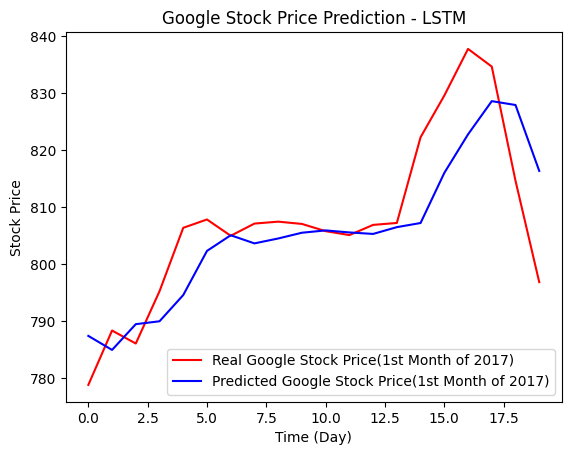

In [251]:
#　Visualising the reults : 查看預測值Y_pred以及真實值的差異
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price(1st Month of 2017)')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price(1st Month of 2017)')
plt.title('Google Stock Price Prediction - LSTM')
plt.xlabel('Time (Day)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [283]:
# 評估 model 對於真實值的誤差 : error = Y_pred - Y_real , error 計算方式 RMSE ( Root Mean Squared Error) : 均方根誤差
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse



8.811813820539573

In [265]:
X_test_testing = np.array(X_test).astype(float)

In [266]:
real_stock_price_64 = real_stock_price.astype(float)

In [284]:
# 另一種評估 model 的好壞 -> model.evaluate()

# model.evluate() 評估出來的參數(指標)(ex: accuracy, val_loss, loss等等) 是依據當初compile的metric(指標選項)而得出的

# 既然Model生出的是歸一化數據，那真實值Y_real的數據也要先歸一化，才可以做loss的計算
real_stock_price_scaled = sc.transform(real_stock_price).astype(float)
loss = math.sqrt(model.evaluate(X_test,real_stock_price_scaled))

1/1 [==============================] - 0s 70ms/step - loss: 2.6871e-04


In [285]:
loss

0.01639223308897783

In [ ]:
'''對於上面兩種誤差的計算方式，還是以真實數據去做比較才可以得出較精確的誤差
    而不是歸一化後的數據去做計算'''